In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.core.display import display, HTML
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import argparse, logging, tempfile, json, sys, pandas
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.max_open_warning'] = 50
display(HTML("<style>.container { width:100% !important; }</style>"))
from trace_utils import *

In [2]:
# %%capture
# with open("../data/trace_trimmed.json") as f:
#     trace = json.load(f)
    
# trace_file = '../data/DLRM_default_1.json'
# trim_trace_by_time(trace_file, 1617835332719386, 1617835333095406)
# with open("../data/trace_trimmed.json") as f:
#     trace = json.load(f)

trace_file = '../data/MLPerf_1.json'
trim_trace_by_time(trace_file, 1617835925909919, 1617835926084651)
with open("../data/trace_trimmed.json") as f:
    trace = json.load(f)

## DLRM with data loading

In [3]:
roots, cc, corrected_start_time, corrected_end_time, sum_skipped_intervals = process_event_hierarchy(trace['traceEvents'], skip_module=False)
print('Num of events: {}, num of root events: {}, num of caller/callee pairs: {}'.format(len(trace['traceEvents']), len(roots), len(cc)))
print('Sum of dataloading time: {}'.format(sum_skipped_intervals))
print("Corrected start time: ", corrected_start_time, ", corrected end time: ", corrected_end_time)
host_runtime = corrected_end_time - corrected_start_time - sum_skipped_intervals
# ---
# device_runtime, device_start_delay = get_device_runtime_and_start_delay(cc, corrected_start_time)
# print("Device start delay: ", device_start_delay)
# ---
device_runtime = host_runtime
# ---
print("Host runtime: ", host_runtime)
print("Device runtime: ", device_runtime)
ops = []
get_operators(roots, ops)
QPS = 1000000 / host_runtime * 10 * 2048
print(f"QPS: {QPS:.2f}")

Num of events: 18015, num of root events: 158, num of caller/callee pairs: 6234
Sum of dataloading time: 60774
Corrected start time:  1617835925909919 , corrected end time:  1617835926084654
Host runtime:  113961
Device runtime:  113961
QPS: 179710.60


### Host runtime breakdown

In [4]:
depth_limit = 3
truncate_count = 3
host_runtime_breakdown = get_host_runtime_breakdown(roots, cc, host_runtime)
print_host_results(host_runtime_breakdown, depth_limit, truncate_count)

Two iteration runtime:               113961 (in us, same below)
     module::backward_pass:                     (52160.0, 45.77%, 10)
          AddmmBackward:                                  (16190.0, 31.04%, 80)
               aten::mm:                                             (9793.0, 60.49%, 150)
                    cudaLaunchKernel:                                          (1755.0, 17.92%, 180)
                    aten::empty:                                               (1028.0, 10.50%, 150)
                    cudaMemsetAsync:                                            (628.0, 6.41%, 90)
                    Others:                                                     (735.0, 7.51%)
                    Unaccounted:                                               (5647.0, 57.66%)
               aten::t:                                              (3423.0, 21.14%, 230)
                    aten::transpose:                                           (1934.0, 56.50%, 230)
           

In [5]:
op_device_runtime = get_device_runtime(ops, cc) # dict: op ex_id -> all its device calls and stats
pprint(op_device_runtime)

{94142: {7: {('Memcpy HtoD (Pageable -> Device)', ((53248,), (53248,), ())): {'count': 1,
                                                                              'runtime': 20.0}}},
 94145: {7: {('Memcpy HtoD (Pageable -> Device)', ((53249,), (53249,), ())): {'count': 1,
                                                                              'runtime': 20.0}}},
 94148: {7: {('Memcpy HtoD (Pageable -> Device)', ((2048, 13), (2048, 13), ())): {'count': 1,
                                                                                  'runtime': 11.0}}},
 94156: {7: {('unrolled_elementwise_kernel', ((512,), (2048, 13), (13, 512), (), ())): {'count': 1,
                                                                                        'runtime': 11.0},
             ('volta_sgemm_128x32_tn', ((512,), (2048, 13), (13, 512), (), ())): {'count': 1,
                                                                                  'runtime': 13.0}}},
 94165: {7: {('vectorized_

 94651: {7: {('vectorized_elementwise_kernel', ((2048, 128), (2048, 128), ())): {'count': 1,
                                                                                 'runtime': 5.0}}},
 94654: {7: {('void splitKreduce_kernel', ((128, 2048), (2048, 256))): {'count': 1,
                                                                        'runtime': 3.0},
             ('volta_sgemm_128x32_nn', ((2048, 128), (128, 256))): {'count': 1,
                                                                    'runtime': 20.0},
             ('volta_sgemm_64x32_sliced1x4_nt', ((128, 2048), (2048, 256))): {'count': 1,
                                                                              'runtime': 21.0}}},
 94670: {7: {('vectorized_elementwise_kernel', ((128,), (128,), ())): {'count': 1,
                                                                       'runtime': 1.0}}},
 94676: {7: {('vectorized_elementwise_kernel', ((128, 256), (128, 256), ())): {'count': 1,
                

                                                                   'runtime': 1.0}}},
 95494: {7: {('vectorized_elementwise_kernel', ((1, 256), (1, 256), ())): {'count': 1,
                                                                           'runtime': 1.0}}},
 95496: {7: {('vectorized_elementwise_kernel', ((2048, 256), (2048, 256), ())): {'count': 1,
                                                                                 'runtime': 7.0}}},
 95499: {7: {('Memset (Device)', ((256, 2048), (2048, 512))): {'count': 1,
                                                               'runtime': 1.0},
             ('Memset (Device)', ((2048, 256), (256, 512))): {'count': 1,
                                                              'runtime': 1.0},
             ('volta_sgemm_128x32_nn', ((2048, 256), (256, 512))): {'count': 1,
                                                                    'runtime': 59.0},
             ('volta_sgemm_32x128_nt', ((256, 2048), (2048, 512)))

 96378: {7: {('Memset (Device)', ((256,), (2048, 512), (512, 256), (), ())): {'count': 1,
                                                                              'runtime': 1.0},
             ('unrolled_elementwise_kernel', ((256,), (2048, 512), (512, 256), (), ())): {'count': 1,
                                                                                          'runtime': 6.0},
             ('volta_sgemm_128x32_tn', ((256,), (2048, 512), (512, 256), (), ())): {'count': 1,
                                                                                    'runtime': 66.0}}},
 96387: {7: {('vectorized_elementwise_kernel', ((2048, 256), (), (0,))): {'count': 1,
                                                                          'runtime': 5.0}}},
 96392: {7: {('unrolled_elementwise_kernel', ((1,), (2048, 256), (256, 1), (), ())): {'count': 1,
                                                                                      'runtime': 2.0},
             ('void gemv2T

 96811: {7: {('vectorized_elementwise_kernel', ((1,), (1,), ())): {'count': 1,
                                                                   'runtime': 1.0},
             ('vectorized_elementwise_kernel', ((1, 256), (1, 256), ())): {'count': 1,
                                                                           'runtime': 1.0},
             ('vectorized_elementwise_kernel', ((128,), (128,), ())): {'count': 1,
                                                                       'runtime': 1.0},
             ('vectorized_elementwise_kernel', ((128, 256), (128, 256), ())): {'count': 1,
                                                                               'runtime': 2.0},
             ('vectorized_elementwise_kernel', ((256,), (256,), ())): {'count': 2,
                                                                       'runtime': 2.0},
             ('vectorized_elementwise_kernel', ((256, 512), (256, 512), ())): {'count': 2,
                                      

 97693: {7: {('Memcpy DtoD (Device -> Device)', ((351,), (351,), ())): {'count': 1,
                                                                        'runtime': 1.0},
             ('_kernel_agent', ((2048, 27, 27), (), (2048, 351), (), ())): {'count': 2,
                                                                            'runtime': 32.0},
             ('indexing_backward_kernel', ((2048, 27, 27), (), (2048, 351), (), ())): {'count': 1,
                                                                                       'runtime': 320.0},
             ('unrolled_elementwise_kernel', ((2048, 351), (2048, 351), ())): {'count': 1,
                                                                               'runtime': 12.0},
             ('vectorized_elementwise_kernel', ((351,), ())): {'count': 4,
                                                               'runtime': 8.0},
             ('vectorized_elementwise_kernel', ((351,), (), ())): {'count': 1,
                  

             ('vectorized_elementwise_kernel', ((512, 13), ())): {'count': 1,
                                                                  'runtime': 1.0},
             ('vectorized_elementwise_kernel', ((512, 1024), ())): {'count': 1,
                                                                    'runtime': 4.0},
             ('vectorized_elementwise_kernel', ((1024,), ())): {'count': 2,
                                                                'runtime': 2.0},
             ('vectorized_elementwise_kernel', ((1024, 479), ())): {'count': 1,
                                                                    'runtime': 4.0},
             ('vectorized_elementwise_kernel', ((1024, 1024), ())): {'count': 1,
                                                                     'runtime': 7.0}}},
 98579: {7: {('vectorized_elementwise_kernel', ((), ())): {'count': 1,
                                                           'runtime': 1.0}}},
 98583: {7: {('unrolled_elementwis

 99473: {7: {('Memset (Device)', ((1024,), (2048, 1024), (1024, 1024), (), ())): {'count': 1,
                                                                                  'runtime': 1.0},
             ('unrolled_elementwise_kernel', ((1024,), (2048, 1024), (1024, 1024), (), ())): {'count': 1,
                                                                                              'runtime': 16.0},
             ('volta_sgemm_128x64_tn', ((1024,), (2048, 1024), (1024, 1024), (), ())): {'count': 1,
                                                                                        'runtime': 441.0}}},
 99482: {7: {('vectorized_elementwise_kernel', ((2048, 1024), (), (0,))): {'count': 1,
                                                                           'runtime': 21.0}}},
 99487: {7: {('Memset (Device)', ((512,), (2048, 1024), (1024, 512), (), ())): {'count': 1,
                                                                                'runtime': 1.0},
         

 99886: {7: {('Memset (Device)', ((256, 2048), (2048, 512))): {'count': 1,
                                                               'runtime': 1.0},
             ('Memset (Device)', ((2048, 256), (256, 512))): {'count': 1,
                                                              'runtime': 1.0},
             ('volta_sgemm_128x32_nn', ((2048, 256), (256, 512))): {'count': 1,
                                                                    'runtime': 59.0},
             ('volta_sgemm_32x128_nt', ((256, 2048), (2048, 512))): {'count': 1,
                                                                     'runtime': 90.0}}},
 99902: {7: {('vectorized_elementwise_kernel', ((256,), (256,), ())): {'count': 1,
                                                                       'runtime': 1.0}}},
 99908: {7: {('vectorized_elementwise_kernel', ((256, 512), (256, 512), ())): {'count': 1,
                                                                               'runtime': 2.

 100785: {7: {('Memset (Device)', ((1024, 2048), (2048, 479))): {'count': 1,
                                                                 'runtime': 1.0},
              ('Memset (Device)', ((2048, 1024), (1024, 479))): {'count': 1,
                                                                 'runtime': 1.0},
              ('volta_sgemm_32x128_nn', ((2048, 1024), (1024, 479))): {'count': 1,
                                                                       'runtime': 197.0},
              ('volta_sgemm_32x128_nt', ((1024, 2048), (2048, 479))): {'count': 1,
                                                                       'runtime': 170.0}}},
 100801: {7: {('vectorized_elementwise_kernel', ((1024,), (1024,), ())): {'count': 1,
                                                                          'runtime': 1.0}}},
 100807: {7: {('vectorized_elementwise_kernel', ((1024, 479), (1024, 479), ())): {'count': 1,
                                                             

                                                                'runtime': 1.0},
              ('vectorized_elementwise_kernel', ((128, 256), ())): {'count': 1,
                                                                    'runtime': 1.0},
              ('vectorized_elementwise_kernel', ((256,), ())): {'count': 2,
                                                                'runtime': 2.0},
              ('vectorized_elementwise_kernel', ((256, 512), ())): {'count': 2,
                                                                    'runtime': 2.0},
              ('vectorized_elementwise_kernel', ((512,), ())): {'count': 2,
                                                                'runtime': 2.0},
              ('vectorized_elementwise_kernel', ((512, 13), ())): {'count': 1,
                                                                   'runtime': 1.0},
              ('vectorized_elementwise_kernel', ((512, 1024), ())): {'count': 1,
                               

                                                                'runtime': 8.0},
              ('vectorized_elementwise_kernel', ((351,), (), ())): {'count': 1,
                                                                    'runtime': 3.0},
              ('vectorized_elementwise_kernel', ((351,), (351,), ())): {'count': 1,
                                                                        'runtime': 2.0},
              ('vectorized_elementwise_kernel', ((2048, 27, 27), ())): {'count': 1,
                                                                        'runtime': 11.0}}},
 101891: {7: {('Memcpy DtoD (Device -> Device)', ((2048, 27, 27), (2048, 27, 27), ())): {'count': 1,
                                                                                         'runtime': 18.0},
              ('vectorized_elementwise_kernel', ((2048, 27, 27), ())): {'count': 1,
                                                                        'runtime': 11.0}}},
 101900: {7: {('volta

 102647: {7: {('vectorized_elementwise_kernel', ((2048, 1),)): {'count': 1,
                                                                'runtime': 2.0}}},
 102654: {7: {('Memcpy HtoD (Pageable -> Device)', ((2048, 1), (2048, 1), ())): {'count': 1,
                                                                                 'runtime': 2.0}}},
 102657: {7: {('Memcpy DtoD (Device -> Device)', ((), (), ())): {'count': 1,
                                                                 'runtime': 1.0},
              ('reduce_kernel', ((2048, 1), ())): {'count': 1, 'runtime': 5.0},
              ('vectorized_elementwise_kernel', ((2048, 1), (2048, 1), (), ())): {'count': 1,
                                                                                  'runtime': 4.0}}},
 102679: {7: {('Memcpy DtoH (Device -> Pageable)', ((), (), ())): {'count': 1,
                                                                   'runtime': 1.0}}},
 102684: {7: {('Memcpy DtoH (Device -> Pageable)'

              ('vectorized_elementwise_kernel', ((351,), (), ())): {'count': 1,
                                                                    'runtime': 3.0},
              ('vectorized_elementwise_kernel', ((351,), (351,), ())): {'count': 1,
                                                                        'runtime': 2.0},
              ('vectorized_elementwise_kernel', ((2048, 27, 27), ())): {'count': 1,
                                                                        'runtime': 11.0}}},
 102932: {7: {('Memcpy DtoD (Device -> Device)', ((2048, 27, 27), (2048, 27, 27), ())): {'count': 1,
                                                                                         'runtime': 18.0},
              ('vectorized_elementwise_kernel', ((2048, 27, 27), ())): {'count': 1,
                                                                        'runtime': 11.0}}},
 102941: {7: {('volta_sgemm_32x128_nt', ((2048, 128, 27), (2048, 27, 27))): {'count': 1,
             

                                                                    'runtime': 3.0},
              ('vectorized_elementwise_kernel', ((351,), (351,), ())): {'count': 1,
                                                                        'runtime': 2.0},
              ('vectorized_elementwise_kernel', ((2048, 27, 27), ())): {'count': 1,
                                                                        'runtime': 11.0}}},
 103973: {7: {('Memcpy DtoD (Device -> Device)', ((2048, 27, 27), (2048, 27, 27), ())): {'count': 1,
                                                                                         'runtime': 18.0},
              ('vectorized_elementwise_kernel', ((2048, 27, 27), ())): {'count': 1,
                                                                        'runtime': 11.0}}},
 103982: {7: {('volta_sgemm_32x128_nt', ((2048, 128, 27), (2048, 27, 27))): {'count': 1,
                                                                             'runtime': 102.0

In [6]:
print_all_device_results(roots, op_device_runtime, device_runtime, depth=0)

module::forward_pass
    aten::to
        Memcpy HtoD (Pageable -> Device):            ( ((53248,), (53248,), ()), 1, 20.0 )
    aten::to
        Memcpy HtoD (Pageable -> Device):            ( ((53249,), (53249,), ()), 1, 20.0 )
    aten::to
        Memcpy HtoD (Pageable -> Device):            ( ((2048, 13), (2048, 13), ()), 1, 11.0 )
    module::forward_pass::bottom_mlp
        aten::linear
            unrolled_elementwise_kernel:                 ( ((512,), (2048, 13), (13, 512), (), ()), 1, 11.0 )
            volta_sgemm_128x32_tn:                       ( ((512,), (2048, 13), (13, 512), (), ()), 1, 13.0 )
        aten::relu
            vectorized_elementwise_kernel:               ( ((2048, 512), (), (0,)), 1, 10.0 )
        aten::linear
            unrolled_elementwise_kernel:                 ( ((256,), (2048, 512), (512, 256), (), ()), 1, 6.0 )
            Memset (Device):                             ( ((256,), (2048, 512), (512, 256), (), ()), 1, 1.0 )
            volta_sgemm_128x3

        aten::linear
            unrolled_elementwise_kernel:                 ( ((128,), (2048, 256), (256, 128), (), ()), 1, 4.0 )
            volta_sgemm_64x32_sliced1x4_tn:              ( ((128,), (2048, 256), (256, 128), (), ()), 1, 25.0 )
        aten::relu
            vectorized_elementwise_kernel:               ( ((2048, 128), (), (0,)), 1, 3.0 )
    module::forward_pass::embedding_lookup
        LookupFunction
            void batched_embedding_forward_kernel_1:                 ( (), 1, 53.0 )
    module::forward_pass::interaction
        aten::cat
            CatArrayBatchedCopy:                               ( ((), ()), 1, 95.0 )
        aten::bmm
            volta_sgemm_32x128_tn:                       ( ((2048, 27, 128), (2048, 128, 27)), 1, 188.0 )
        aten::to
            Memcpy HtoD (Pageable -> Device):            ( ((351,), (351,), ()), 1, 1.0 )
        aten::to
            Memcpy HtoD (Pageable -> Device):            ( ((351,), (351,), ()), 1, 1.0 )
        aten::

        vectorized_elementwise_kernel:               ( ((512,), (512,), ()), 1, 1.0 )
    torch::autograd::AccumulateGrad
        vectorized_elementwise_kernel:               ( ((512, 13), (512, 13), ()), 1, 1.0 )
Optimizer.step#SGD.step
    vectorized_elementwise_kernel:               ( ((512, 13), (512, 13), ()), 1, 1.0 )
    vectorized_elementwise_kernel:               ( ((512,), (512,), ()), 2, 2.0 )
    vectorized_elementwise_kernel:               ( ((256, 512), (256, 512), ()), 2, 7.0 )
    vectorized_elementwise_kernel:               ( ((256,), (256,), ()), 2, 2.0 )
    vectorized_elementwise_kernel:               ( ((128, 256), (128, 256), ()), 1, 2.0 )
    vectorized_elementwise_kernel:               ( ((128,), (128,), ()), 1, 1.0 )
    vectorized_elementwise_kernel:               ( ((1024, 479), (1024, 479), ()), 1, 9.0 )
    vectorized_elementwise_kernel:               ( ((1024,), (1024,), ()), 2, 2.0 )
    vectorized_elementwise_kernel:               ( ((1024, 1024), (1024,

### Device runtime breakdown

In [8]:
dt_breakdown = device_runtime_breakdown(roots, op_device_runtime, depth=0)
# pprint(dt_breakdown)
truncate_count = 10
flatten = {}
for stream, v in dt_breakdown.items():
    print("Stream: {}".format(stream))
    flatten[stream] = {}
    print_major_device_results(device_runtime, dt_breakdown[stream], flatten[stream], truncate_count=truncate_count)
# pprint(flatten)

Stream: 7
    Total device time: 113961 (in us, same below)
    Device idle time: 68185.0 (59.83%)
    Device active time: 45776.0 (40.17%)
      module::backward_pass:                               (28762.0, 62.83%, 10)
        AddmmBackward:                                         (1133.0, 39.62%, 2)                                              ((2048, 1024),)
          volta_sgemm_32x128_nn:                                     (390.0, 51.11%, 1)                                 ((2048, 1024), (1024, 1024))
          volta_sgemm_32x128_nt:                                     (371.0, 48.62%, 1)                                 ((1024, 2048), (2048, 1024))
          Memset (Device):                                             (1.0, 0.13%, 1)                                 ((2048, 1024), (1024, 1024))
          Memset (Device):                                             (1.0, 0.13%, 1)                                 ((1024, 2048), (2048, 1024))
        AddmmBackward:                   

########################
STREAM: 7
########################


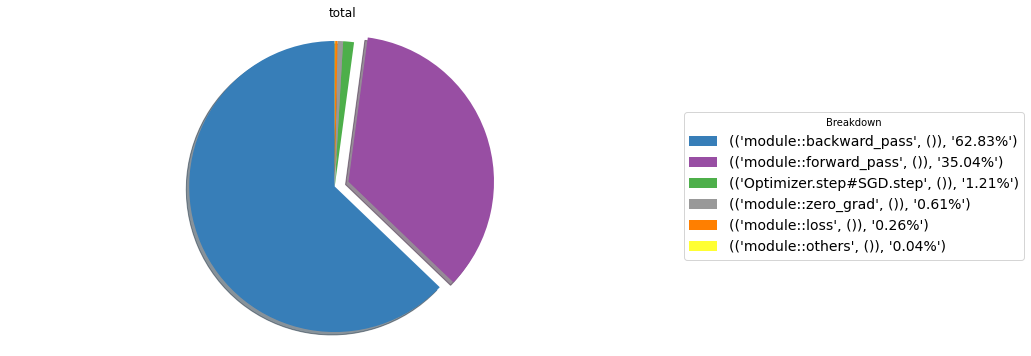

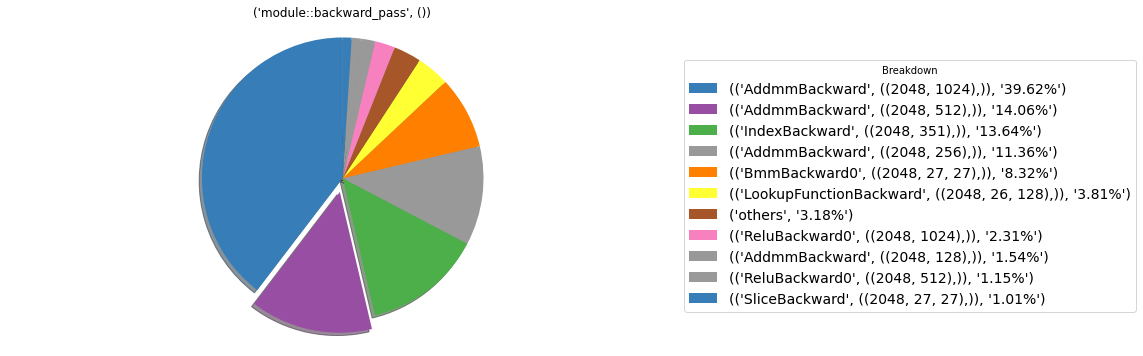

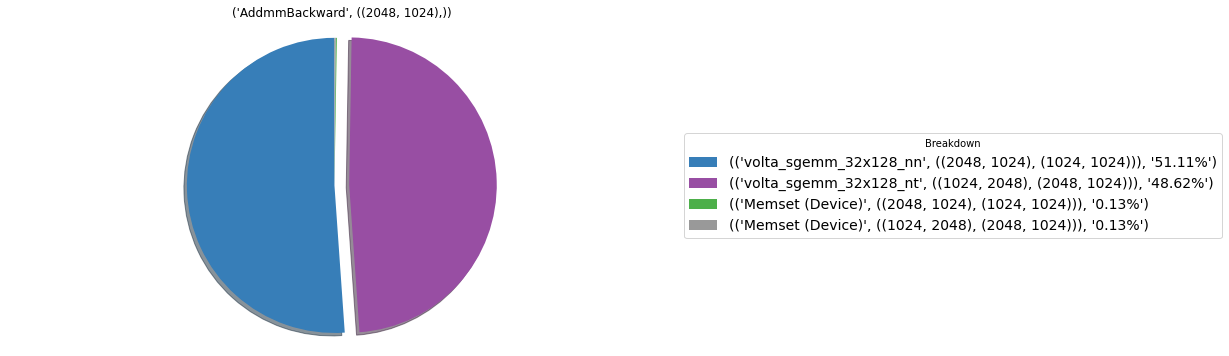

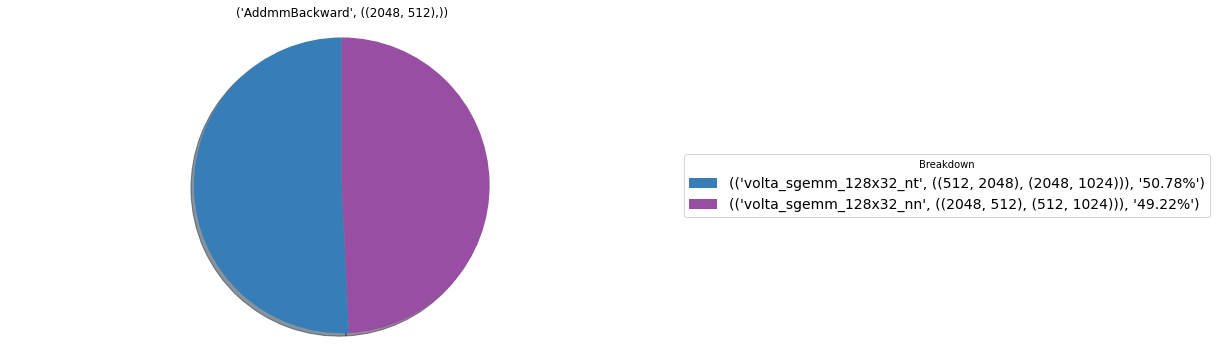

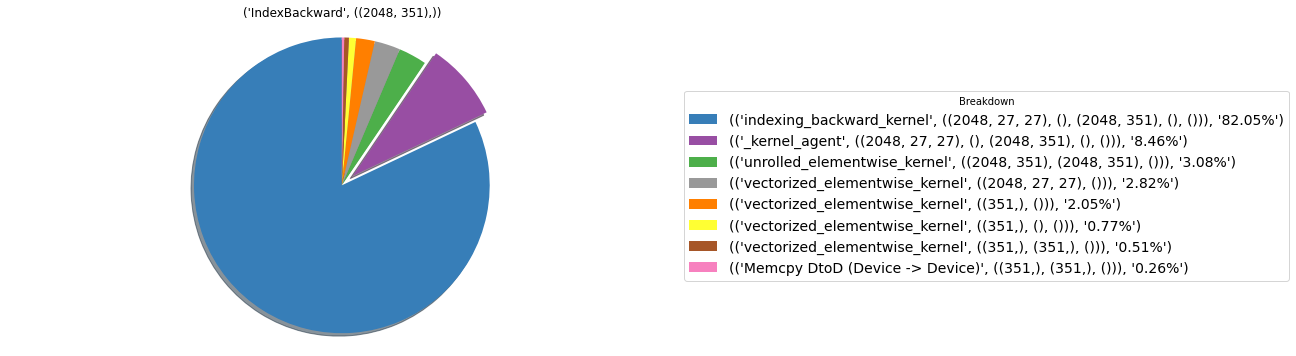

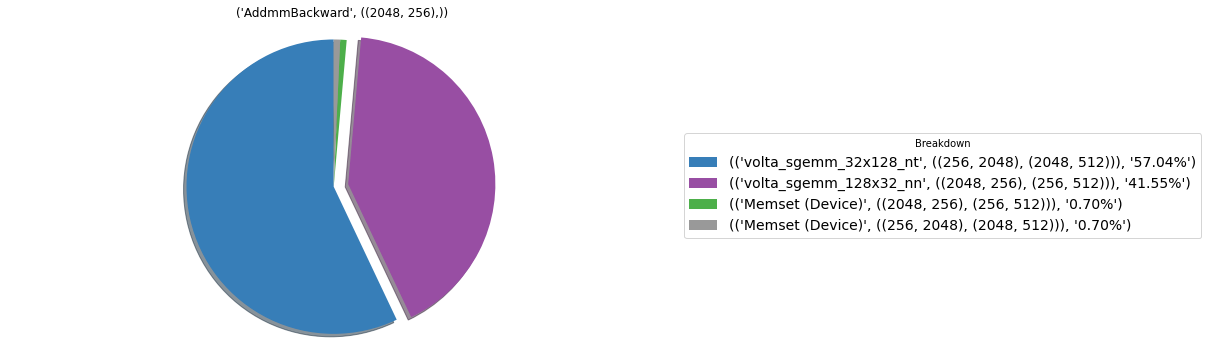

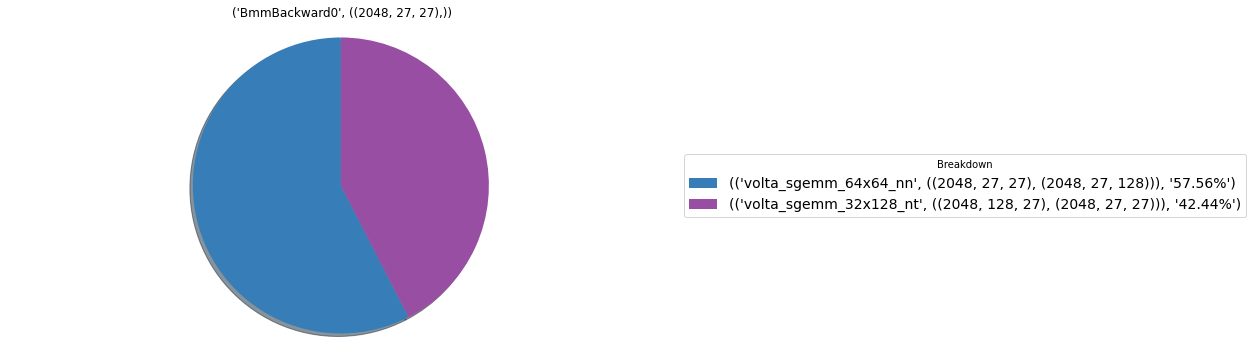

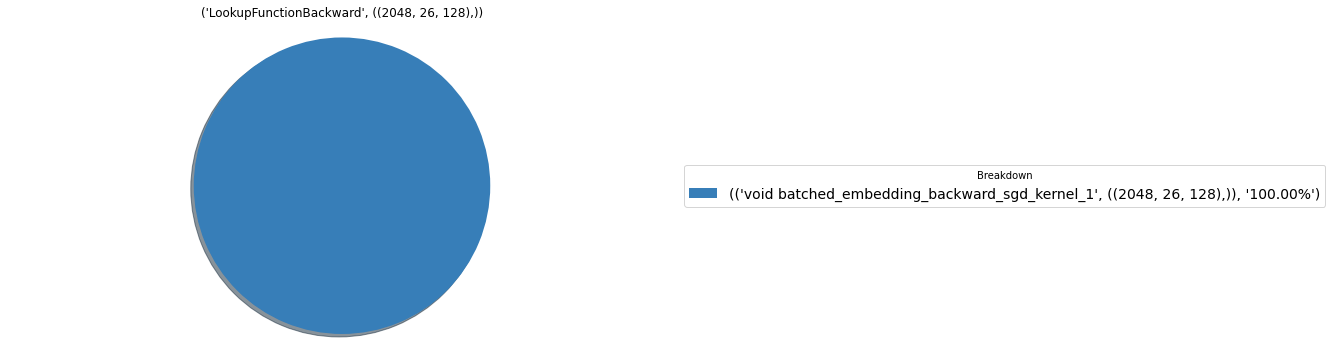

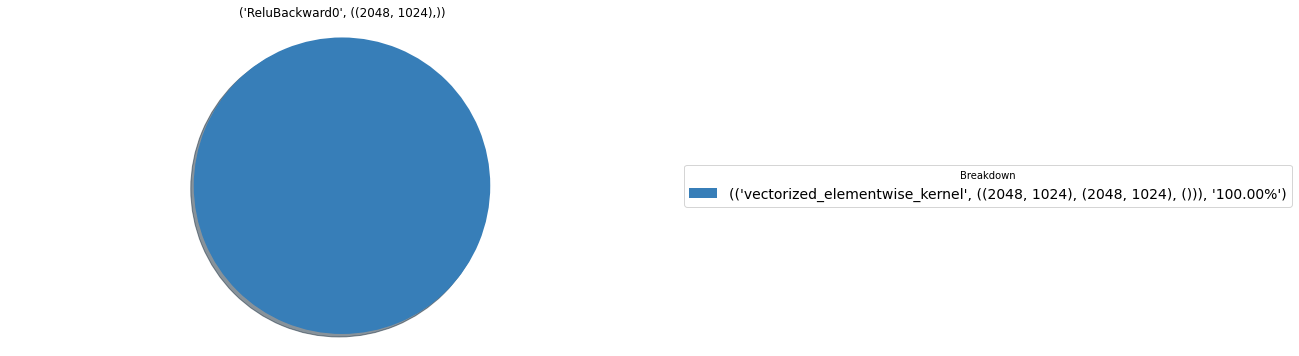

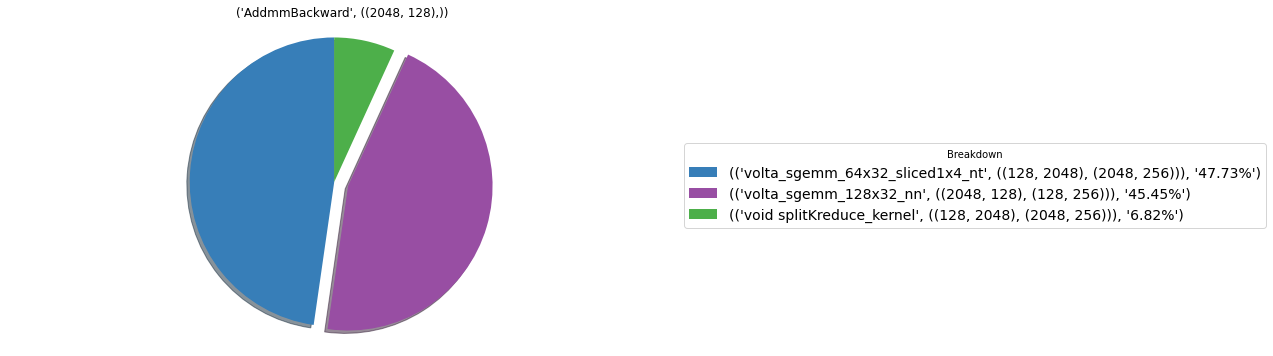

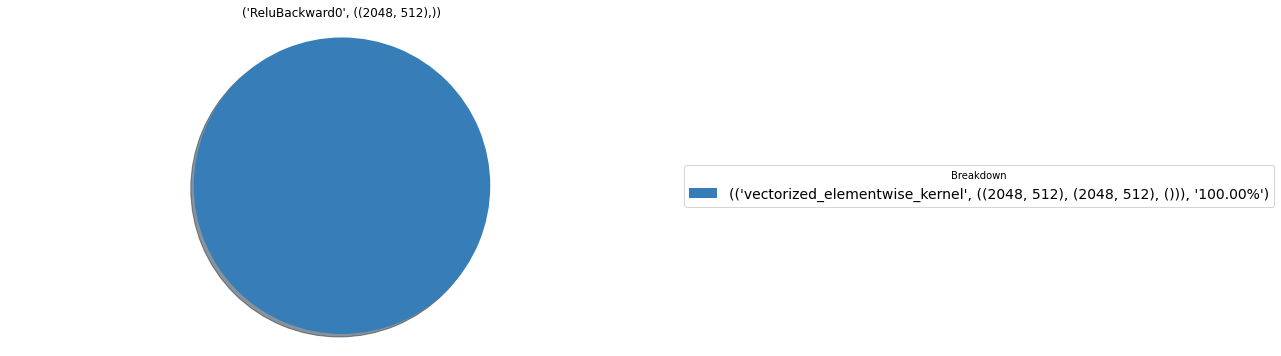

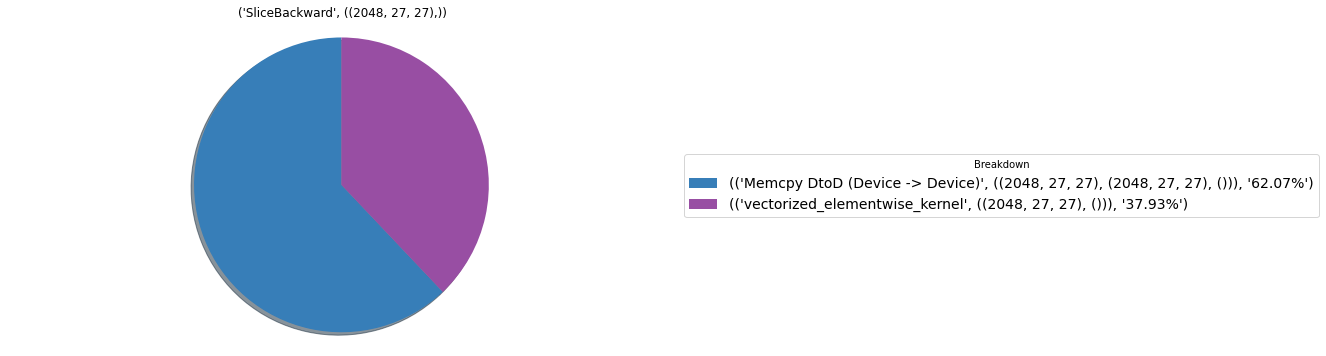

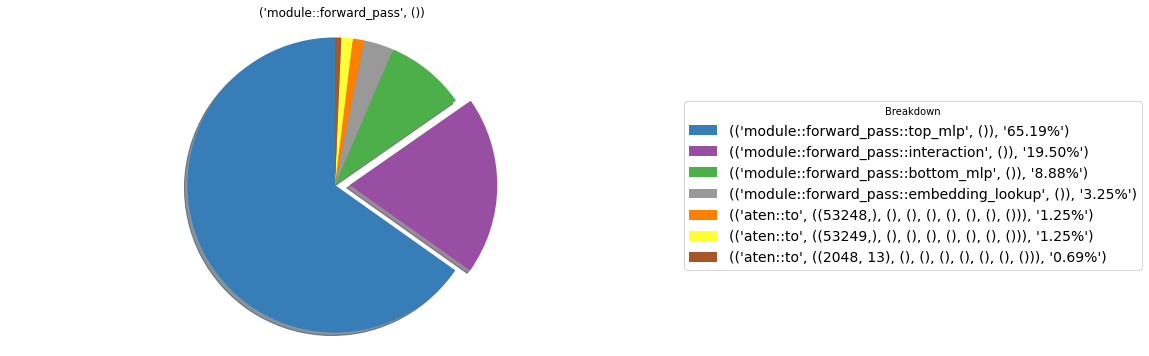

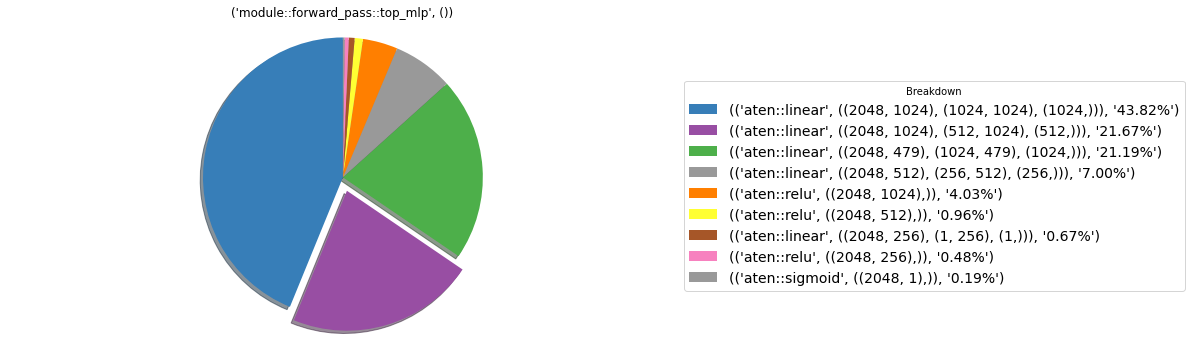

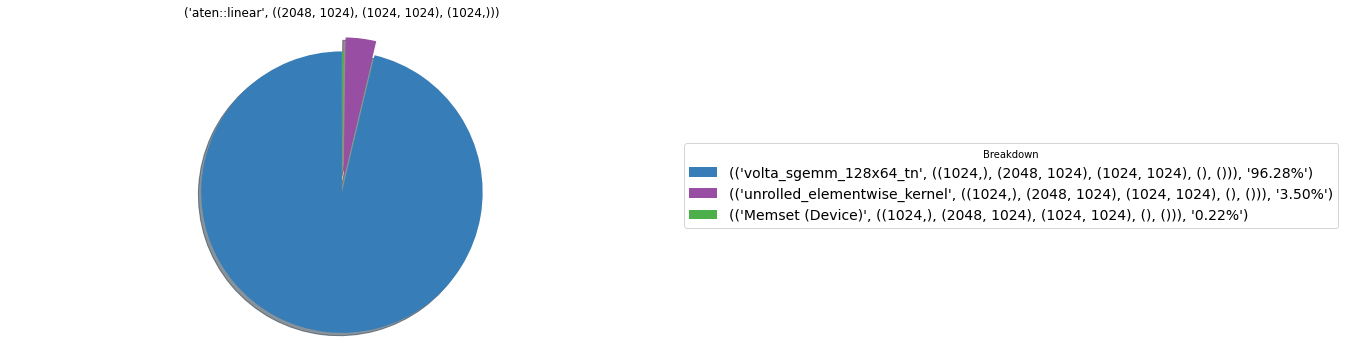

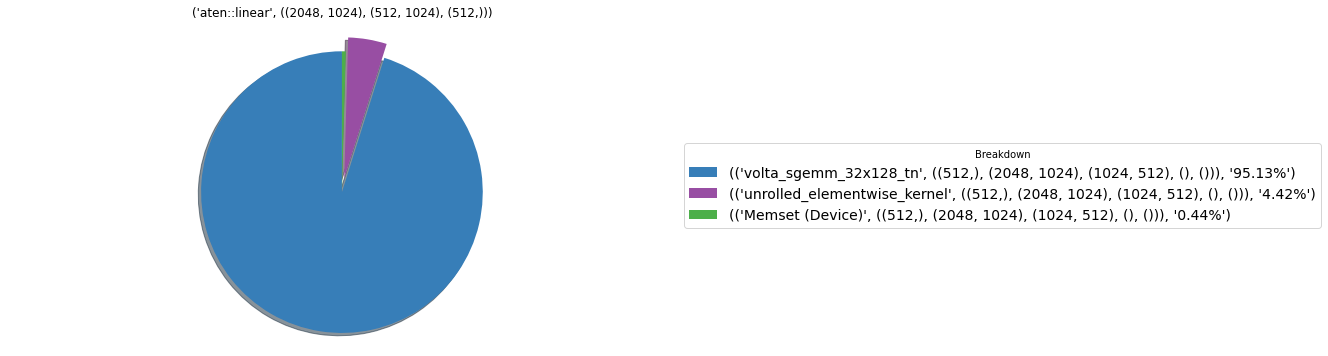

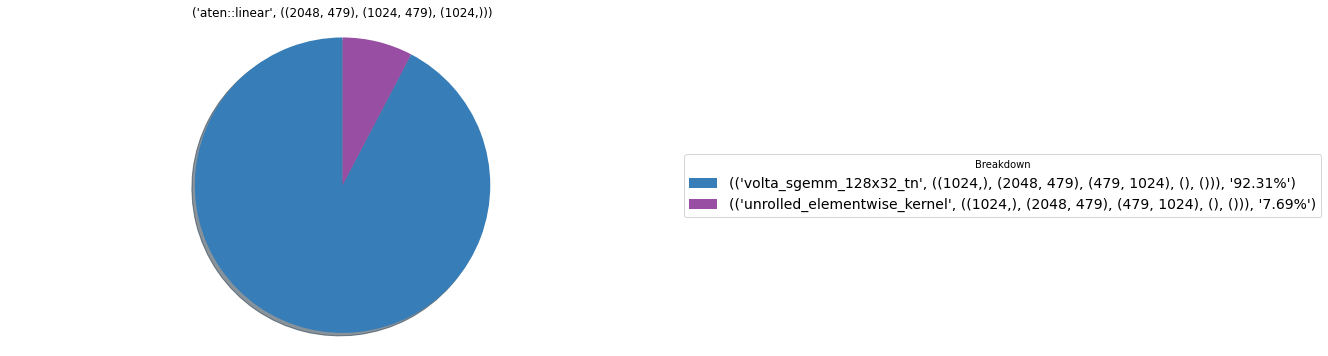

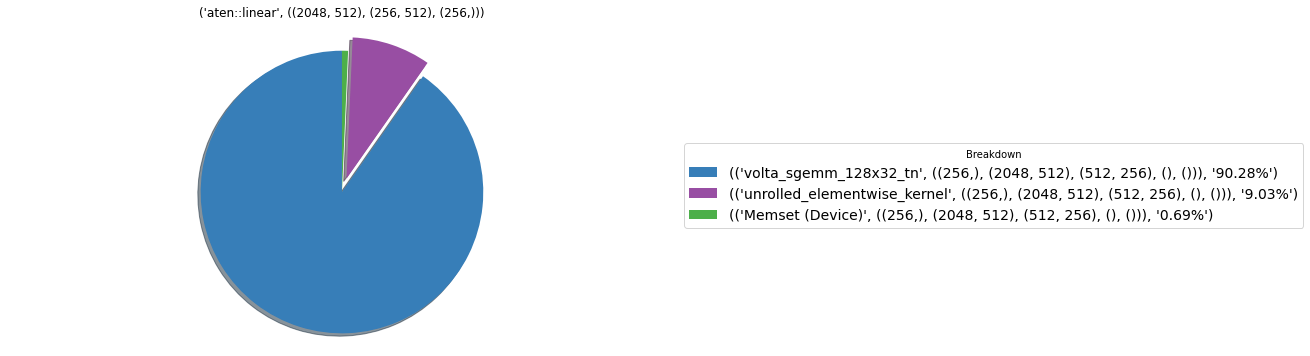

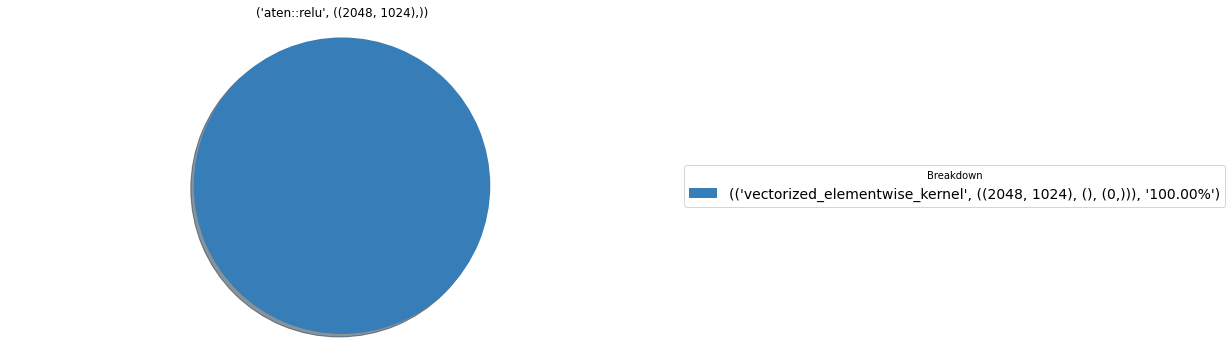

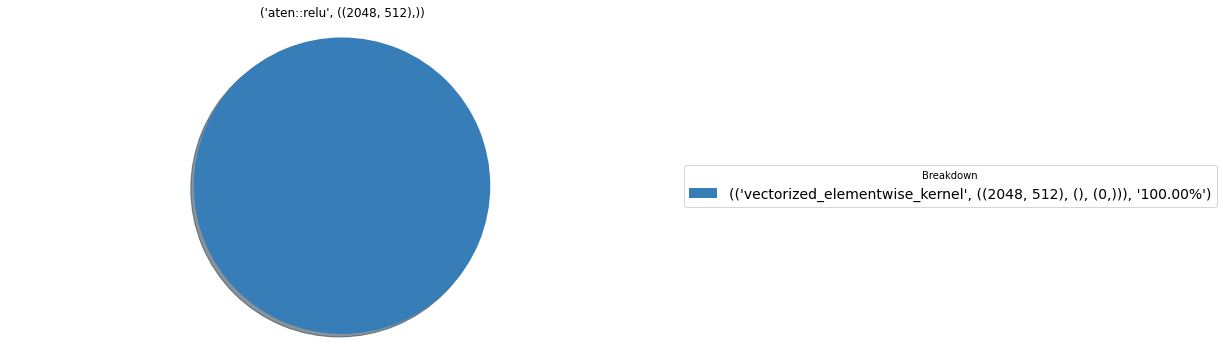

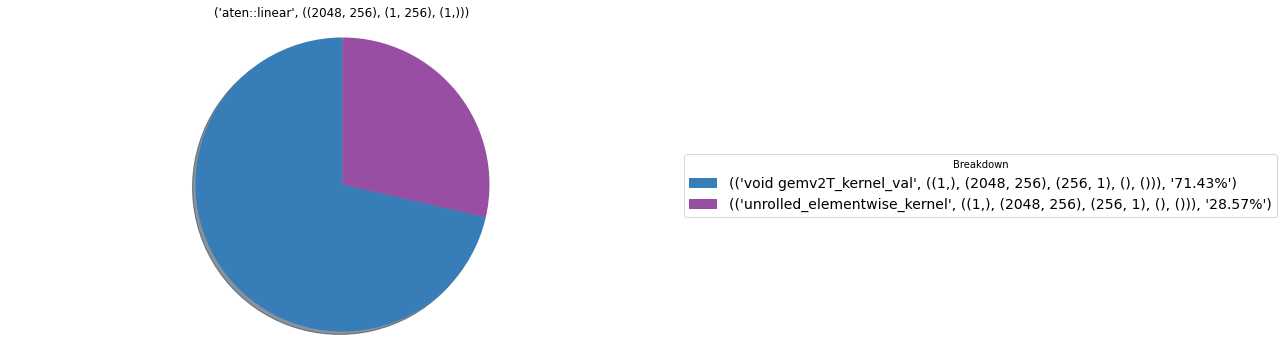

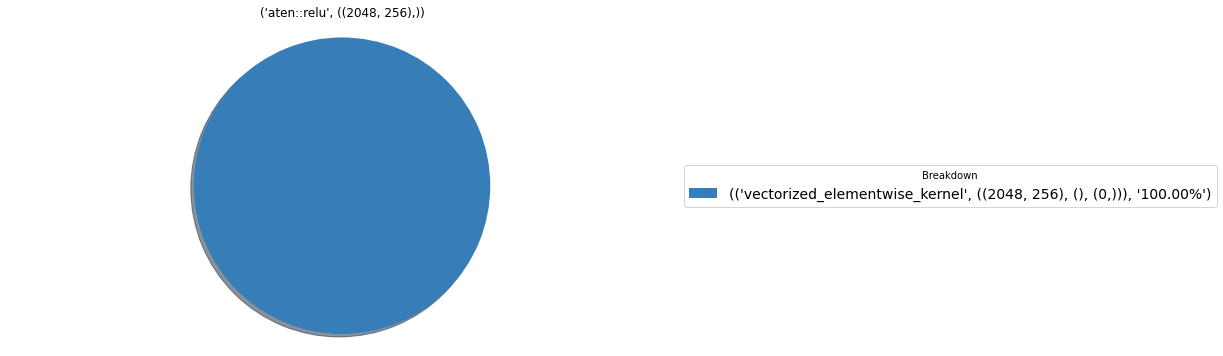

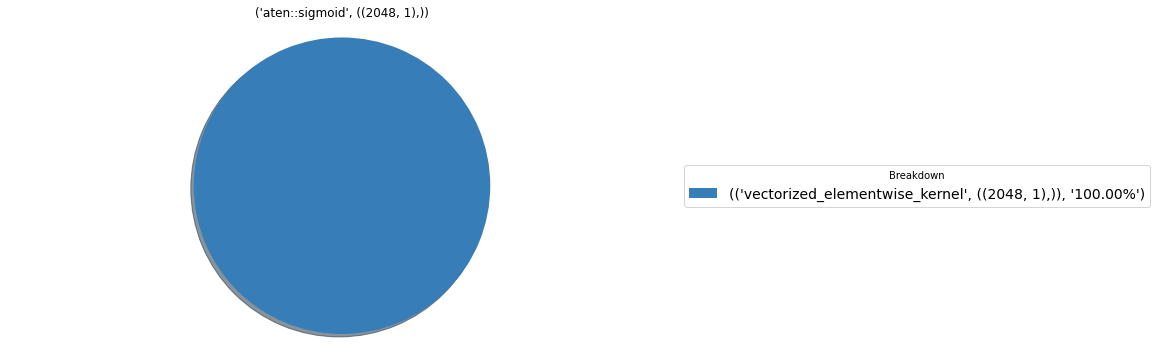

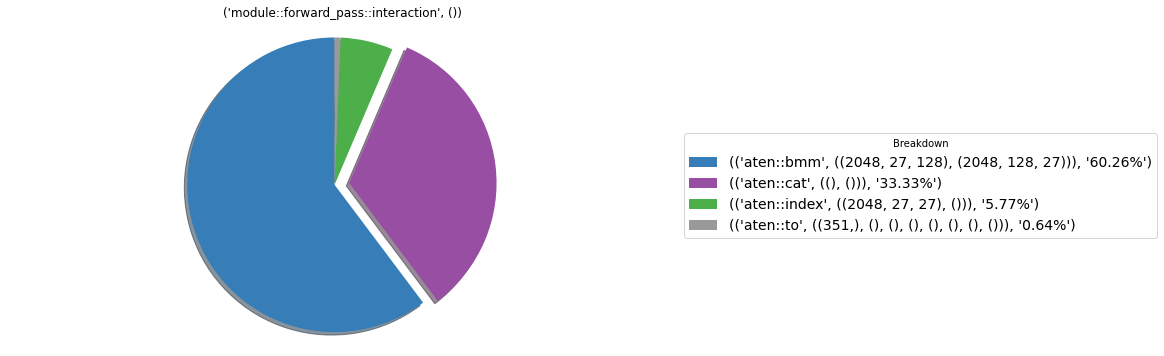

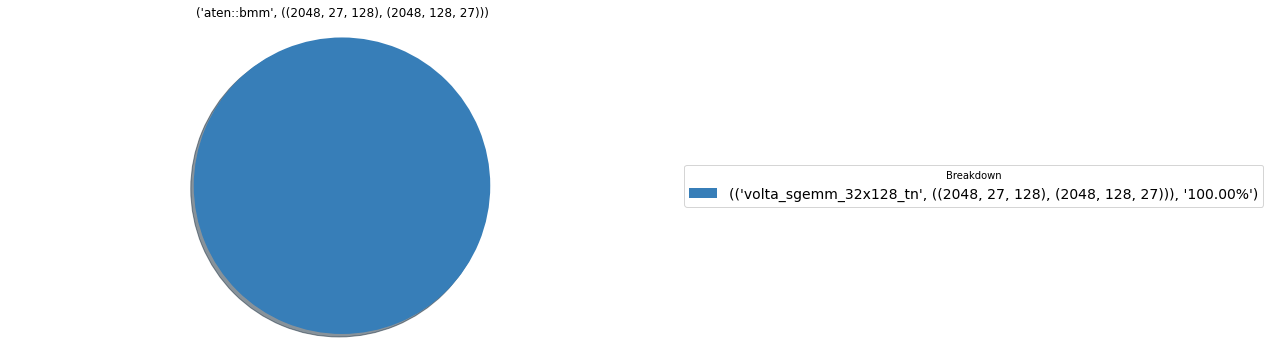

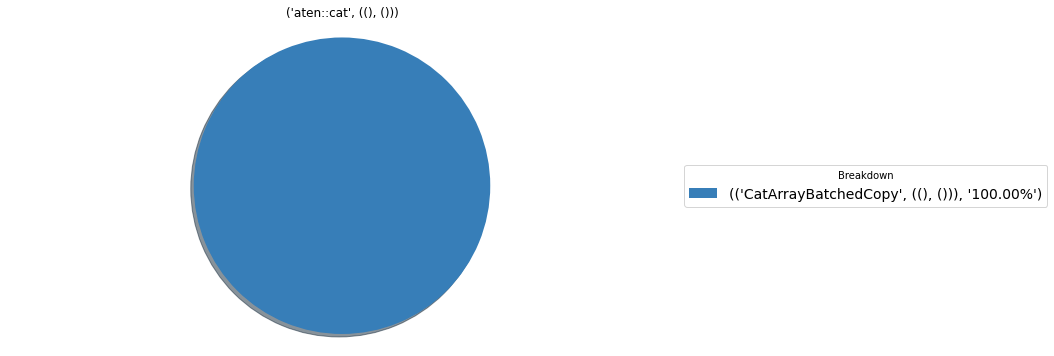

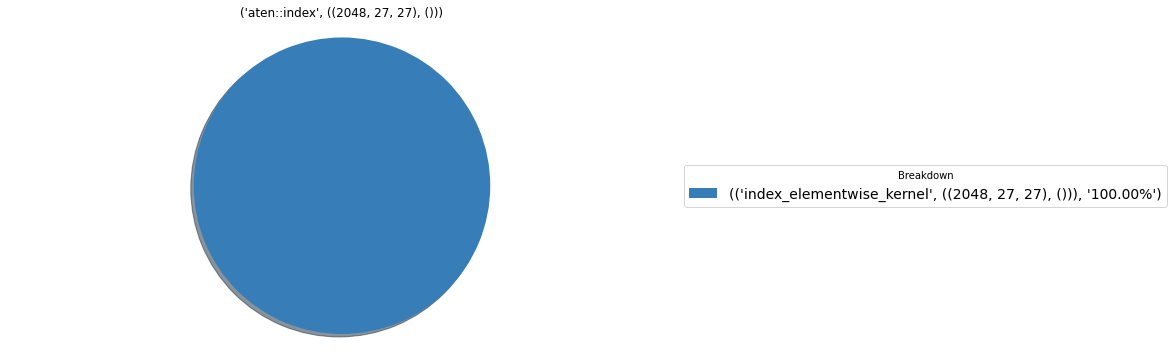

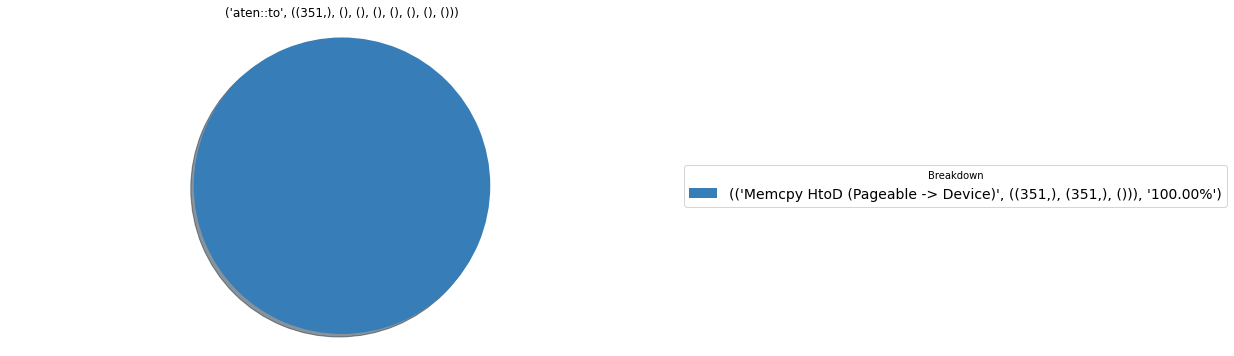

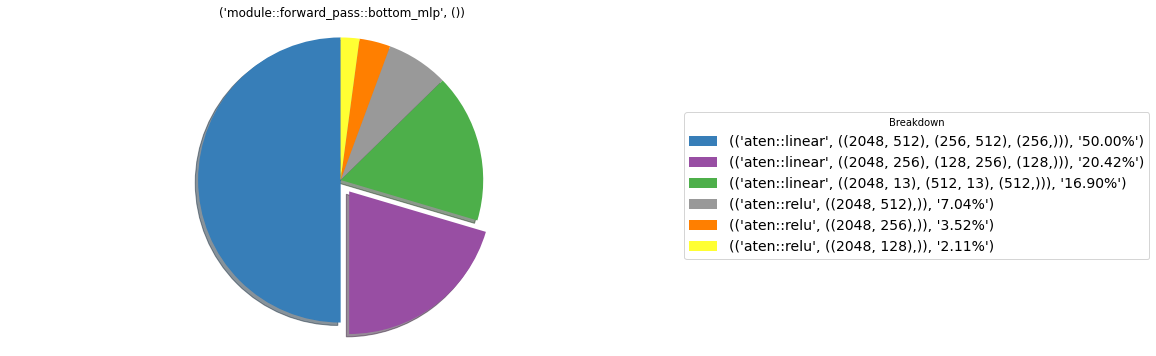

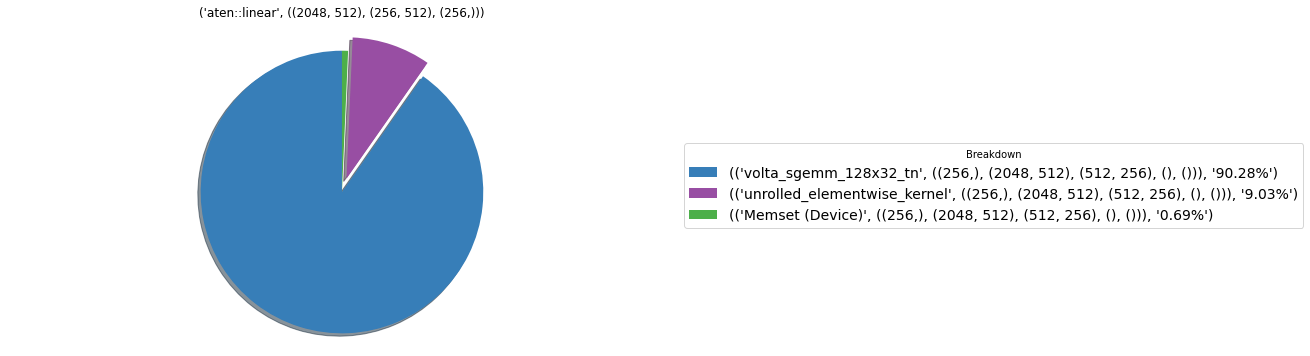

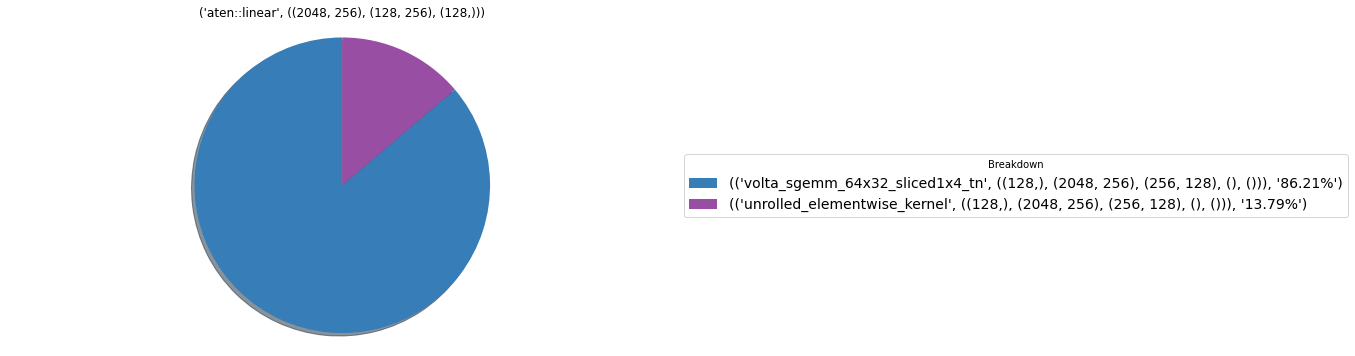

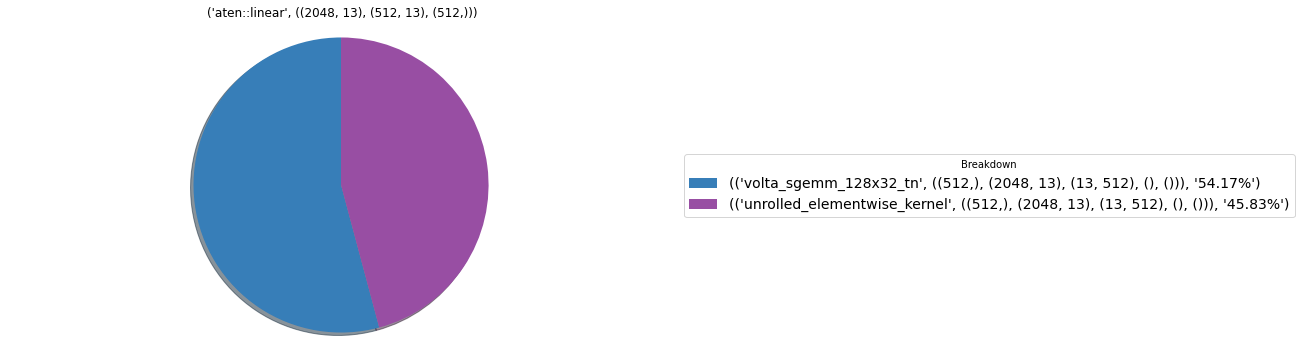

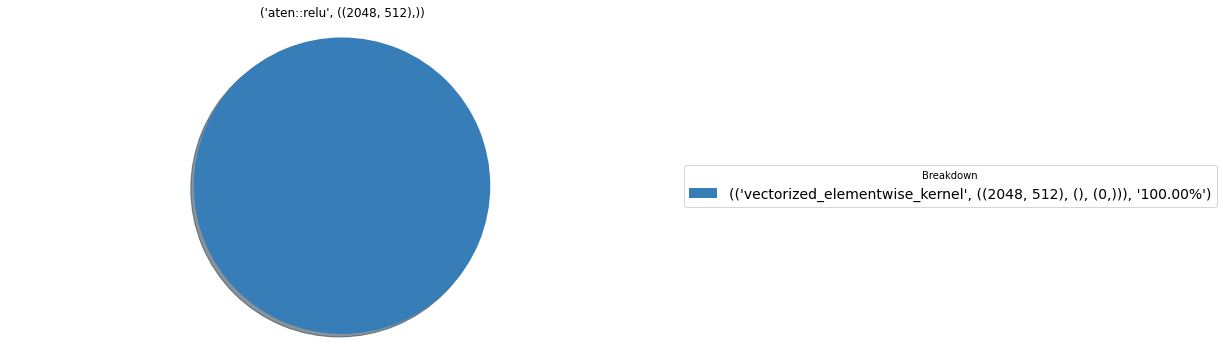

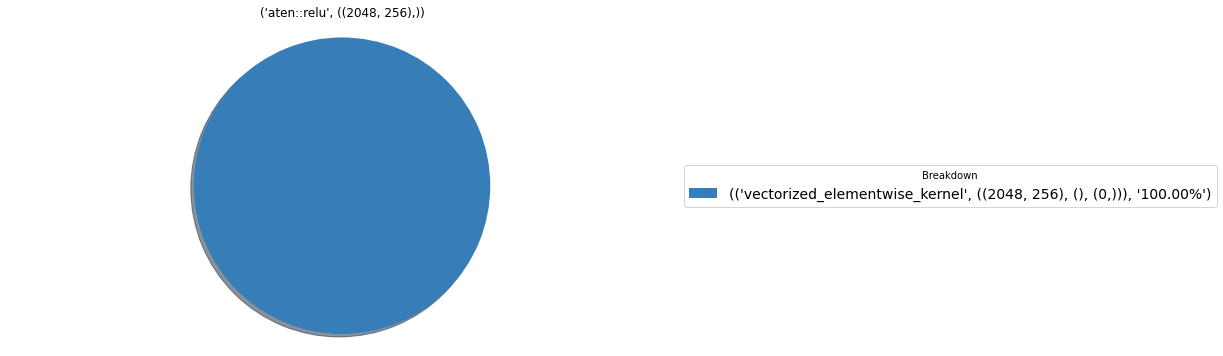

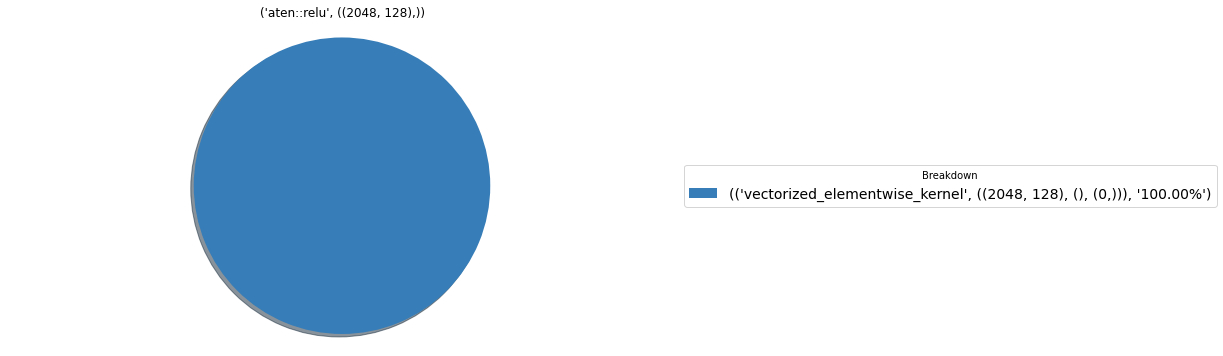

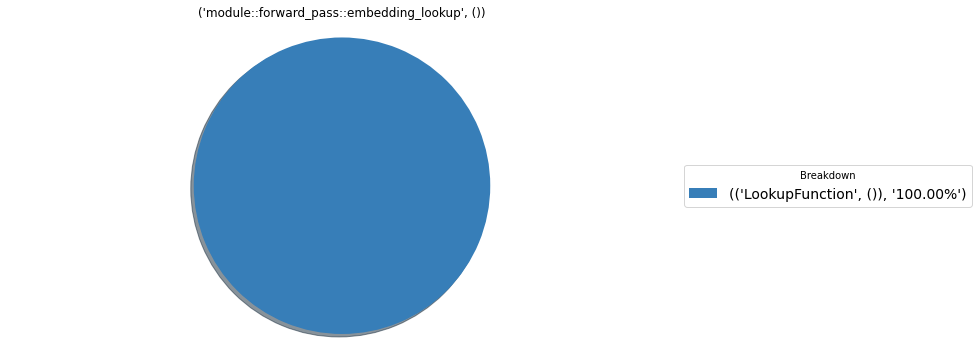

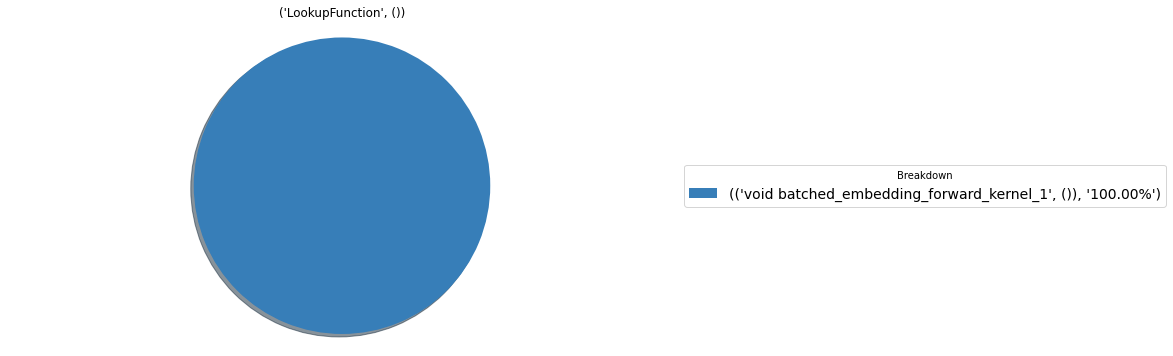

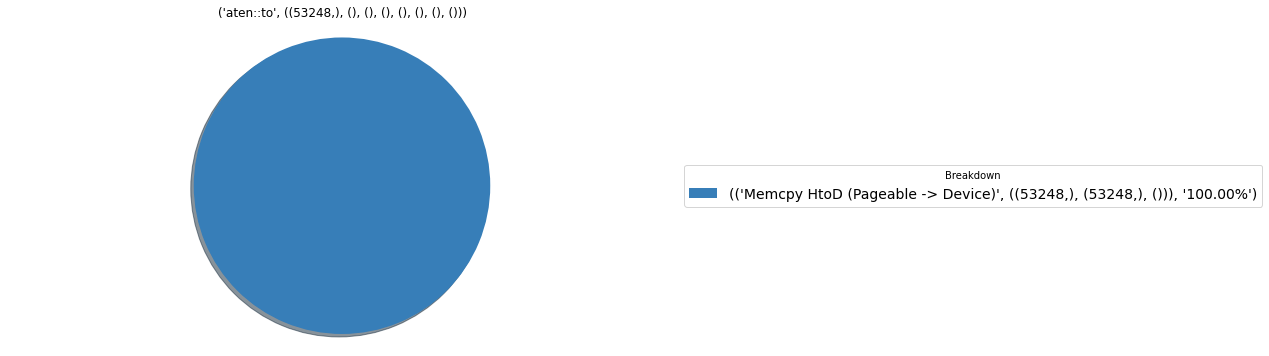

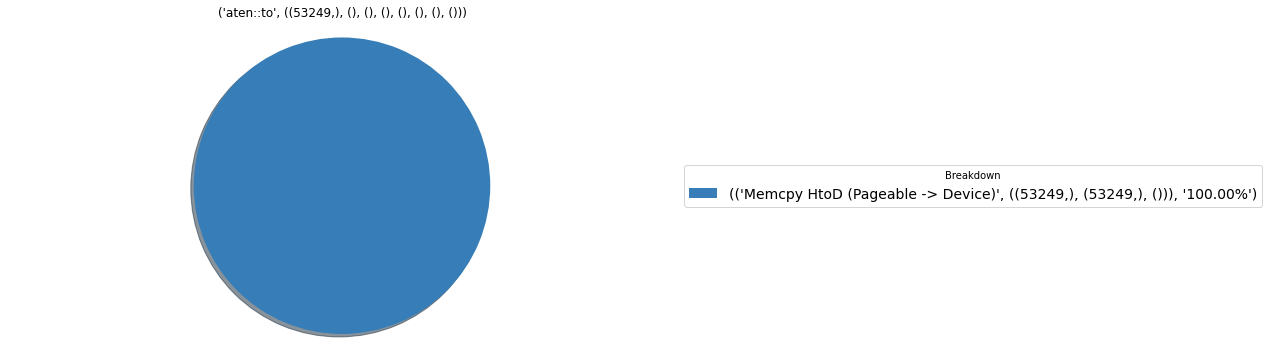

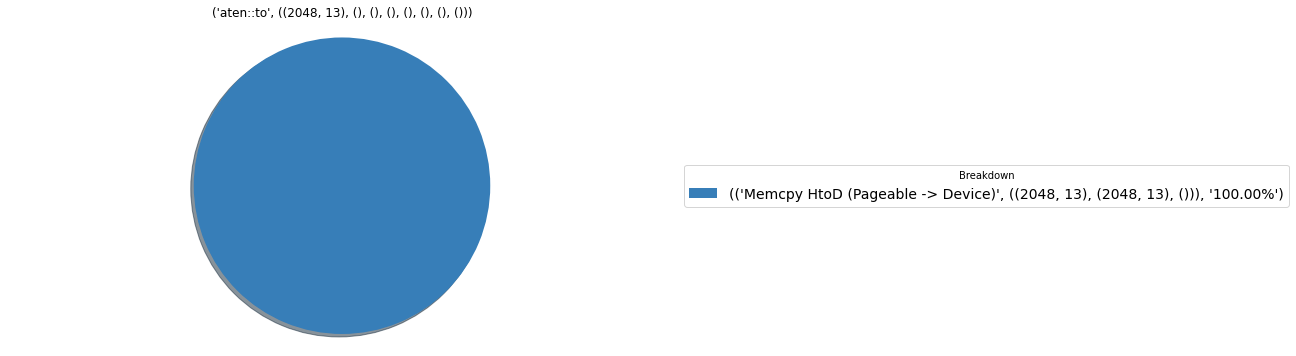

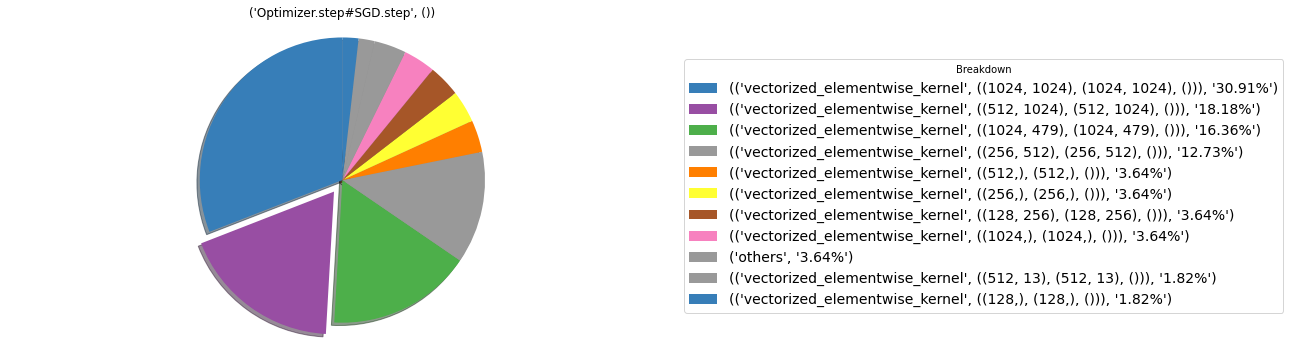

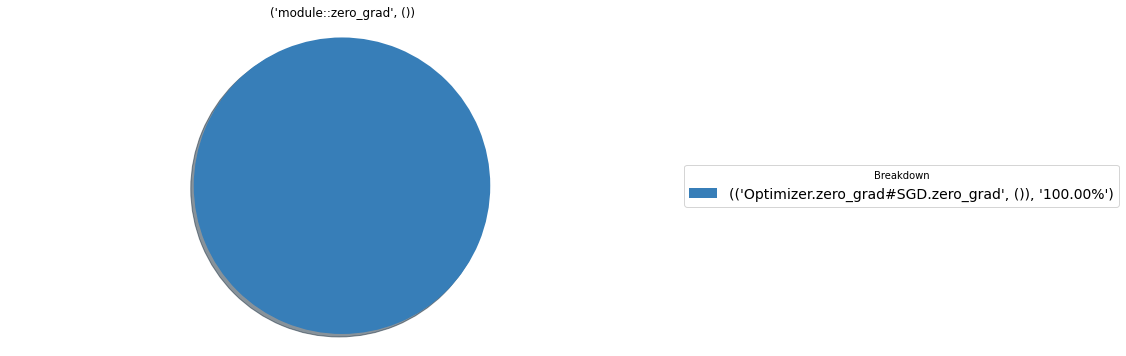

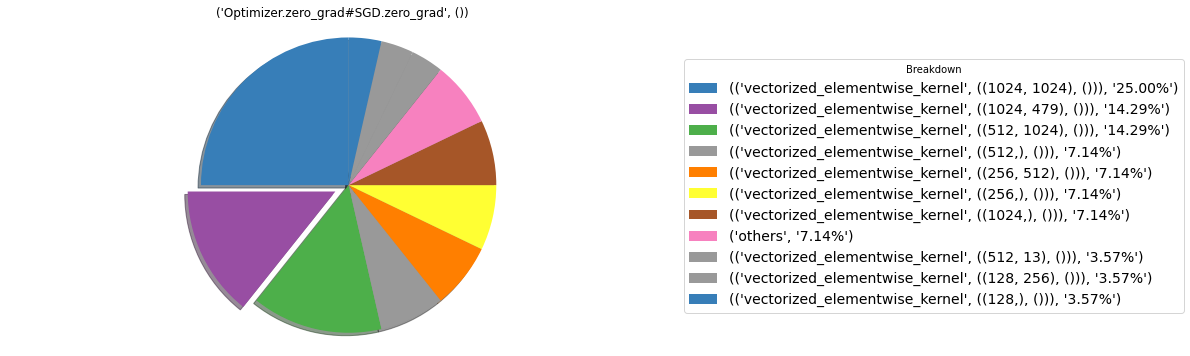

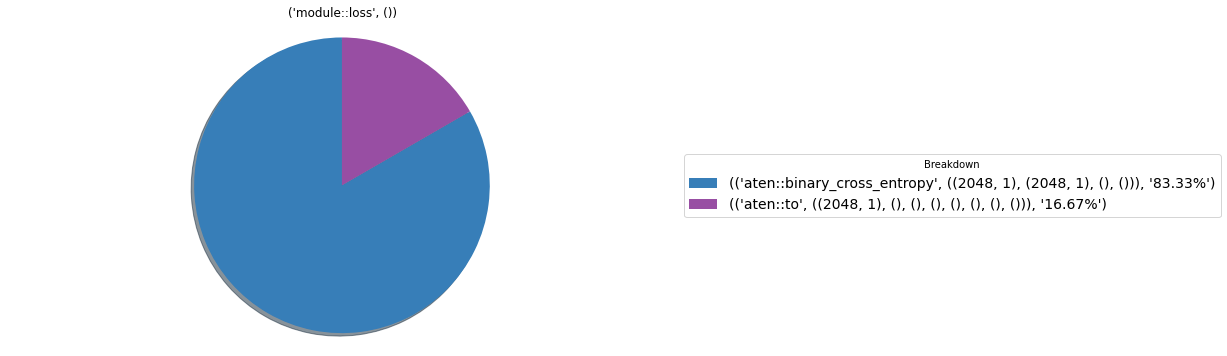

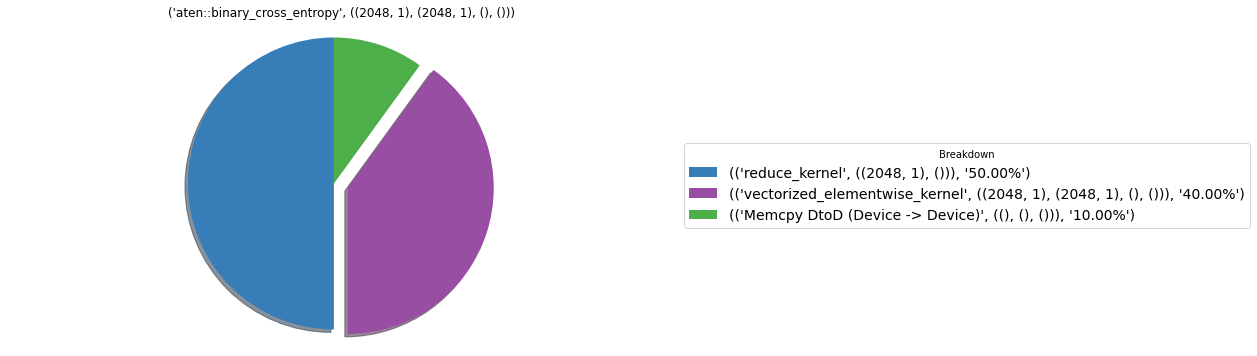

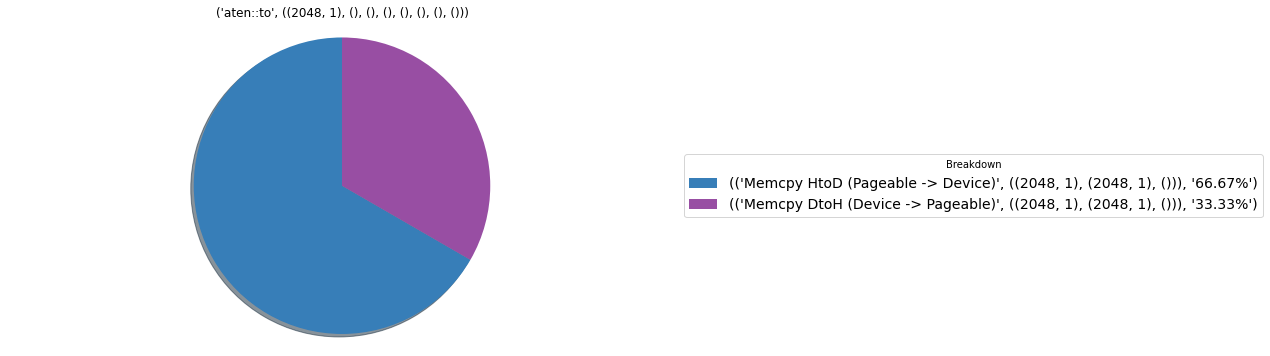

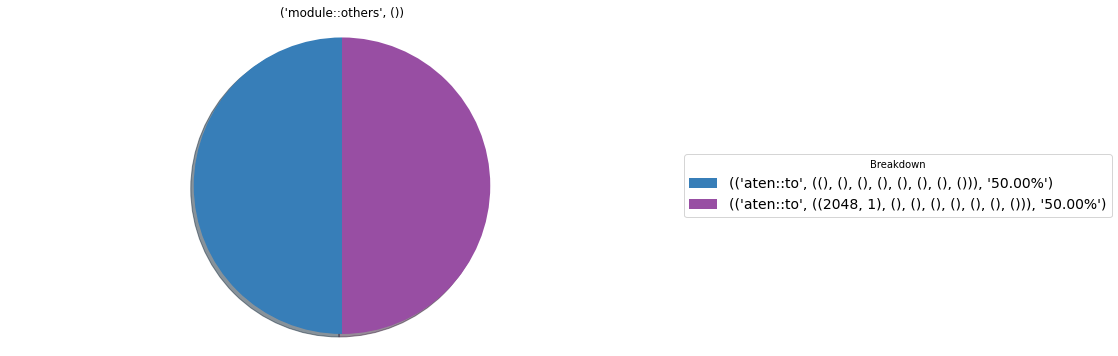

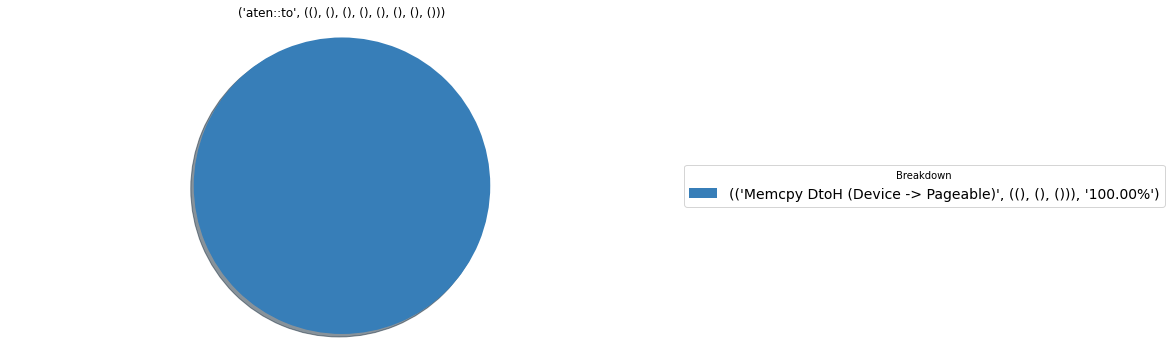

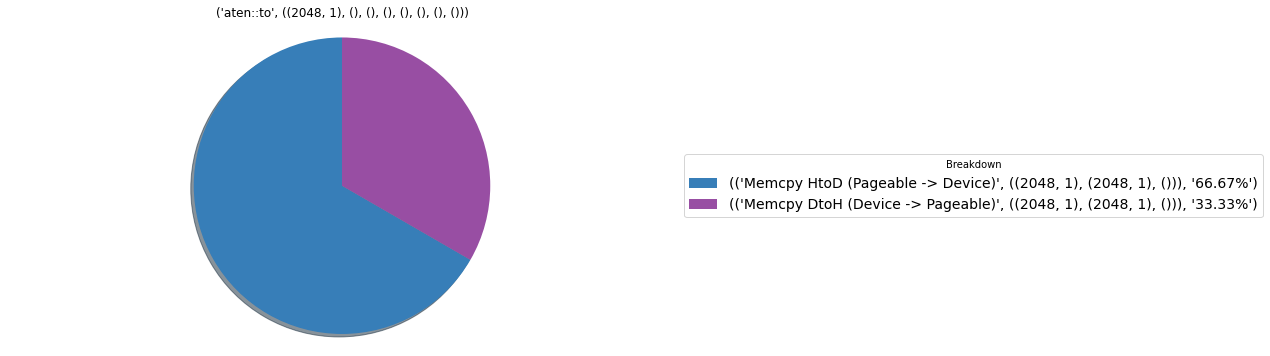

In [9]:
from matplotlib import cm
cs=cm.Set1([1, 3, 2, 25, 4, 5, 6, 7, 8, 11])

def plot_pie_chart(flatten, key="total", truncate_count=100, depth=0):
    d = flatten[key]
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    stats = sorted(d["subs"].items(), key=lambda x: x[1], reverse=True)
    labels = [x[0] for x in stats]
    runtime = [x[1] for x in stats]
    explode = np.zeros(len(runtime))
    if len(explode) > 2:
        explode[1] = 0.1

    fig1, ax1 = plt.subplots(figsize=(12, 6))
    wedges, texts = ax1.pie(runtime, explode=explode, shadow=True, startangle=90, colors=cs)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(key)
    
    ax1.legend(wedges, zip(labels, ["{:.2f}%".format(r / d["runtime"] * 100) for r in runtime]),
          title="Breakdown",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=14)
    
    for label in labels:
        if label in flatten:
            plot_pie_chart(flatten, key=label, truncate_count=truncate_count, depth=depth+1)

    if depth == 0:
        plt.show()

for stream, v in flatten.items():
    print("########################")
    print("STREAM: {}".format(stream))
    print("########################")
    plot_pie_chart(v, truncate_count=truncate_count)

In [10]:
def histogram(df, perc=True, is_abs=False, bins=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0]):
    count = len(df)
    ret = {}
    if is_abs:
        tmp_bins = []
        for i in range(0, len(bins) - 1):
            tmp_bins.append(-bins[len(bins) - 1 - i])
        for b in bins:
            tmp_bins.append(b)
        bins = tmp_bins
    for idx, b in enumerate(bins):
        if idx == 0:
            continue
        ret[(bins[idx-1], bins[idx])] = 0
    for x in df:
        for idx, b in enumerate(bins):
            if idx == 0:
                continue
            if x >= bins[idx-1] and x < bins[idx]:
                ret[(bins[idx-1], bins[idx])] += 1
                break
    for b, c in sorted(ret.items(), key=lambda x: x[0]):
        if perc:
            print("{:.0f}% - {:.0f}%: {:.2f}%".format(b[0] * 100, b[1] * 100, c / count * 100))
        else:
            print("{:.2f} - {:.2f}: {:.2f}%".format(b[0], b[1], c / count * 100))
    return ret

In [17]:
# Type 1 overhead: between two op calls
# Type 2 overhead: before the first device call, op-specific
# Type 3 overhead: after the last device call, op-specific
# Type 4 overhead: kernel launches themselves, kernel-launch-type-specific
# Type 5 overhead: sum of gaps between kernel launches, op-specific
overheads = {'independent': {}}
overheads['independent']['t1'] = [] # Independent from names
overheads['independent']['t4'] = {} # Independent from names

for i, op in enumerate(ops):
    name = op.name()
    if name not in overheads.keys():
        overheads[name] = {}

    if 't2' not in overheads[name].keys():
        overheads[name]['t2'] = []
    if 't3' not in overheads[name].keys():
        overheads[name]['t3'] = []
    if 't5' not in overheads[name].keys():
        overheads[name]['t5'] = []

    if op.has_device_calls:
        launches = get_event_all_kernel_launches(op)
        overheads[name]['t2'].append(launches[0].start_time() - op.start_time())
        overheads[name]['t3'].append(op.end_time() - launches[-1].end_time())
        overheads[name]['t5'].append(sum([launches[i].start_time() - launches[i-1].end_time() for i in range(1, len(launches))]))
        
        # T4 is launch-type-dependent
        for x in launches:
            if x.name() not in overheads['independent']['t4']:
                overheads['independent']['t4'][x.name()] = []
            overheads['independent']['t4'][x.name()].append(x.duration())
    else:
        if op.name not in overheads[name].keys():
            overheads[name]['t5'] = []
        overheads[name]['t5'].append(op.duration())

    if i == 0:
        continue
    prev_op = ops[i-1]
    
    # Only consider adjacent ops under the SAME MODULE
    if prev_op.parent != op.parent:
        continue
        
    gap = op.start_time() - prev_op.end_time()
    if gap < 200: # Skip dataloading gaps
        overheads['independent']['t1'].append(gap) # Some pairs of ops are actually inserted by a runtime call which has been filtered from ops. TODO: fix it.

# # T1: mean ~= 21, std ~= 20
# histogram(overheads['independent']['t1'], perc=False, bins=[0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 200, 100000])
# print(np.mean(overheads['independent']['t1']), np.std(overheads['independent']['t1']))

# # T2, T3, T5
# t2 = {k: (np.mean(v['t2']), np.std(v['t2'])) for k, v in overheads.items() if k != 'independent' and len(v['t2']) > 0}
# pprint(t2)
# t3 = {k: (np.mean(v['t3']), np.std(v['t3'])) for k, v in overheads.items() if k != 'independent' and len(v['t3']) > 0}
# pprint(t3)
# t5 = {k: (np.mean(v['t5']), np.std(v['t5'])) for k, v in overheads.items() if k != 'independent' and len(v['t5']) > 0}
# pprint(t5)

# # T4
# for t, l in overheads['independent']['t4'].items():
#     print(t, np.mean(l), np.std(l))

21.135643564356435 20.367135652438584
{'AddmmBackward': (60.1375, 4.87786774625963),
 'BinaryCrossEntropyBackward': (64.4, 2.690724809414742),
 'BmmBackward0': (63.1, 2.5475478405713994),
 'IndexBackward': (36.4, 1.6248076809271923),
 'LookupFunction': (62.5, 5.661271941887264),
 'LookupFunctionBackward': (38.8, 0.4),
 'Optimizer.step#SGD.step': (135.6, 3.2310988842807022),
 'Optimizer.zero_grad#SGD.zero_grad': (92.7, 2.41039415863879),
 'ReluBackward0': (24.985714285714284, 1.553731518845216),
 'SigmoidBackward': (25.1, 0.8306623862918076),
 'SliceBackward': (34.3, 1.9519221295943134),
 'aten::binary_cross_entropy': (72.4, 2.1540659228538015),
 'aten::bmm': (56.6, 1.8547236990991407),
 'aten::cat': (46.15, 7.15733889095661),
 'aten::index': (61.9, 2.4269322199023193),
 'aten::linear': (89.125, 13.560397302439188),
 'aten::ones_like': (34.9, 1.4456832294800963),
 'aten::relu': (49.957142857142856, 7.213946243781088),
 'aten::sigmoid': (24.6, 1.3564659966250536),
 'aten::to': (30.0375, 

In [26]:
pd.set_option('display.max_rows', None)
op_names = []
op_input_shapes = []
op_duration = []
for op in ops:
    if op.parent is not None and (op.parent.name().startswith("module::forward_pass") or op.parent.name().startswith("module::backward_pass")):
        op_names.append(op.name())
        op_input_shapes.append(op.input_shape())
        op_duration.append(op.duration())
forward_backward_ops = pd.DataFrame(list(zip(op_names, op_input_shapes, op_duration)), columns=["names", "shapes", "duration on host (us)"])
forward_backward_ops

,names,shapes,duration on host (us)
0,aten::empty,"((), (), (), (), (), ())",4
1,aten::to,"((815797,), (), (), (), (), (), (), ())",406
2,aten::to,"((16385,), (), (), (), (), (), (), ())",91
3,aten::to,"((2048, 512), (), (), (), (), (), (), ())",422
4,aten::zeros,"((), (), (), (), ())",24
5,aten::empty,"((), (), (), (), (), ())",5
6,aten::linear,"((2048, 512), (512, 512), (512,))",414
7,aten::relu,"((2048, 512),)",94
8,aten::linear,"((2048, 512), (64, 512), (64,))",168
9,aten::relu,"((2048, 64),)",84


### Multistream analysis

In [26]:
all_kernels = []
for _, c in cc.items():
    for _, v in c["callees"].items():
        if v["executor"] is not None:
            all_kernels.append(v["executor"])
all_kernels = sorted(all_kernels, key=lambda x: x.start_time())

idle_time = 0
last_end = all_kernels[0].start_time() + all_kernels[0].duration()
overlapped = 0
for k in all_kernels:
    if k.start_time() > last_end:
        idle_time += k.start_time() - last_end
        last_end = k.start_time() + k.duration()
    else:
        last_end = max(last_end, k.start_time() + k.duration())
        overlapped += min(last_end, k.start_time() + k.duration()) - k.start_time()

print("device_runtime", device_runtime)
print("idle_time:", idle_time)
print("overlapped_time", overlapped)

device_runtime 33956
idle_time: 18407
overlapped_time 14
